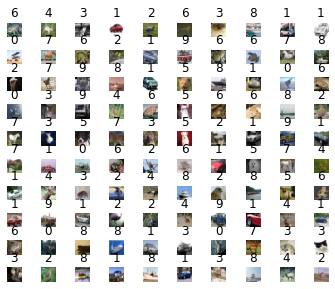

In [108]:
import tarfile
import numpy as np
import matplotlib.pyplot as plt

#****CIFARPATH NEEDS TO BE SET
#File Needs to be unzipped to '.tar' NOT '.tar.gz' & BINARY format
curr = os.getcwd()
cifarPath = os.path.join(curr,'cifar-10-binary.tar')

# Function for extracting cifar10 images from zip file into 5 training batches and one test batch
def cifar10_Load(path):    
    #Names of image batch files in cifar-10-python.tar
    batchNames = ['cifar-10-batches-bin/data_batch_1.bin',
             'cifar-10-batches-bin/data_batch_2.bin',
             'cifar-10-batches-bin/data_batch_3.bin',
             'cifar-10-batches-bin/data_batch_4.bin',
             'cifar-10-batches-bin/data_batch_5.bin',
             'cifar-10-batches-bin/test_batch.bin']
    
    with tarfile.open(path) as tar_object:
         batchSize = 10000 * ( 32*32*3 + 1 )                     #Total number of bytes for each bin file. Each File Contains 10,000 32x32 color images with 10,000 labels
         totalBytes = np.zeros(batchSize*6, dtype="uint8")    #Total number bytes for all files. 5 Training & 1 Test files
         members = []
         for file in batchNames:
             members.append(tar_object.getmember(file))          #Gets members from tar file and ensures sorted from batch 1 to 5              

         for i, member in enumerate(members):                    #Retrieves byte data from all batch files
            f = tar_object.extractfile(member)
            totalBytes[i * batchSize:(i + 1) * batchSize] = np.frombuffer(f.read(), 'B')
    
    labels = totalBytes[::3073]
    images = np.delete(totalBytes, np.arange(0, totalBytes.size, 3073)).reshape(-1, 3072).astype('float32')/255 #Delete labels from totalbytes using array of label index locations then convert into 60,000 image x 3072 byte array (byte values in decimal value i.e. 255 = 0xFF)
    
    #print(labels[0:5])
    #print("--------------")
    #print(images[0:5,0:5])
    #print("--------------")
    
    trainImages = images[0:50000,:]
    trainLabels = labels[0:50000]
    testImages = images[50000:60000,:]
    testLabels = labels[50000:60000]
    
    return trainImages, trainLabels, testImages, testLabels


def random_IndexGen(numIndices):
    indices = np.random.randint(0,50000, numIndices)
    return indices


def image_Gen(imgArray, imgLabel, indices):
    #img1 = imgArray[110,:]
    imageHolder = np.zeros((32,32,3,len(indices))) 
    labelHolder = np.zeros(len(indices))
    for pic in range(0, len(indices)):
        img = imgArray[indices[pic],:]
        labelHolder[pic] = imgLabel[indices[pic]]
        for hue in range(0,3):
            for row in range(0,32):
                for col in range(0,32):
                    imageHolder[row,col,hue,pic] = img[1024*hue + 32*row + col]
    return imageHolder, labelHolder


def image_Display(images, labels):            #This assumes a 4 dimensional array with the 4 dimension representing image index
    numImages = images.shape[3]
    numCol = 10                               #Could be improved here to make number of Col/Rows dynamic and dependent on input data
    numRow = int(images.shape[3]/numCol)
    f, ax = plt.subplots(numRow,numCol)
    for row in range(0, numRow):
        for col in range(0, numCol):
            ax[row, col].imshow(images[:,:,:,10*row+col])
            ax[row, col].title.set_text(int(labels[10*row+col]))
            ax[row, col].axis('off')
    plt.subplots_adjust(top=0.95, bottom=0.05, wspace=0.2, hspace=0.9)
    plt.show()


#Load data from cifar10
trainImg, trainLbl, testImg, testLbl = cifar10_Load(cifarPath)
#Generate 100 Random Indices
randIndices = random_IndexGen(100)
#Format Byte Data input 4Dimensional Array
pictures, picLabels = image_Gen(trainImg, trainLbl, randIndices)
#Display Images
image_Display(pictures, picLabels)

In [109]:
import scipy
#from dnn_utils_v2 import relu, relu_backward

# Transpose train and test data to get features row-wise for nn model
trainData, testData, testLbl = trainImg.T, testImg.T, testLbl.T
print(trainData.shape)

# One-hot encoded train and test labels for softmax output
one_hot_train = np.zeros((50000, 10))
#one_hot_test = np.zeros((10000, 10))

for i in range(50000):
    one_hot_train[i, trainLbl[i]] = 1
#for j in range(10000):    
#    one_hot_test[j, testLbl[j]] = 1
   
# Transpose train and test one-hot encoded labels for nn model
one_hot_train = one_hot_train.T
#one_hot_test = one_hot_test.T   

print(one_hot_train.shape)

def relu(X):
    return np.maximum(0,X)

def reluDer(X):
    X[X<=0] = 0
    X[X>0] = 1
    return X

def softmax(A):
    expA = np.exp(A - np.max(A))
    return expA / expA.sum(axis=0, keepdims=True)

#nums = np.array([4, 5, 6])
#print(softmax(nums))

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x)
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h)
    b2 = np.zeros(shape=(n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

# Sanity Check
parameters = initialize_parameters(6, 4, 3)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

(3072, 50000)
(10, 50000)
W1 = [[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387 ]
 [ 1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071]
 [-0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842]
 [ 0.04221375  0.58281521 -1.10061918  1.14472371  0.90159072  0.50249434]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[ 0.90085595 -0.68372786 -0.12289023 -0.93576943]
 [-0.26788808  0.53035547 -0.69166075 -0.39675353]
 [-0.6871727  -0.84520564 -0.67124613 -0.0126646 ]]
b2 = [[0.]
 [0.]
 [0.]]


In [110]:
# Dummy data for sanity checks
np.random.seed(0)
    
X = np.random.randn(6, 10)
X1 = X[:,0].reshape(6,1)
print(X1.shape)

one_hot = np.array([1,0,0]).reshape(3,1)

#tD = trainData[:,0].reshape(3072,1)
#print(tD.shape)

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size 3072
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The softmax output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Implement Forward Propagation to calculate A2 (scores)
    Z1 = np.dot(W1,X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = softmax(Z2)
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

# Sanity Check
A2, cache = forward_propagation(X1, parameters)
print("Z1 = " + str(cache["Z1"]))
print("A1 = " + str(cache["A1"]))
print("Z2 = " + str(cache["Z2"]))
print("A2 = " + str(cache["A2"]))

(6, 1)
Z1 = [[ 5.11299926]
 [ 2.42683897]
 [-2.72211558]
 [ 1.75032709]]
A1 = [[5.11299926]
 [2.42683897]
 [0.        ]
 [1.75032709]]
Z2 = [[ 1.3088758 ]
 [-0.77707268]
 [-5.58685868]]
A2 = [[0.88872981]
 [0.11037071]
 [0.00089948]]


In [111]:

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of size 3072
    Y -- one-hot encoded "true" labels vector 
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters["W1"]
    W2 = parameters["W2"]
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2-Y
    dW2 = np.dot(dZ2,A1.T)
    db2 = np.sum(dZ2, axis=1, keepdims=True)
    
    dprev = np.dot(W2.T,dZ2)
    
    dZ1 = dprev*reluDer(A1) 
    dW1 = np.dot(dZ1,X.T)
    db1 = np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

# Sanity Check
grads = backward_propagation(parameters, cache, X1, one_hot)
print("dW1 = " + str(grads["dW1"]))
print("db1 = " + str(grads["db1"]))
print("dW2 = " + str(grads["dW2"]))
print("db2 = " + str(grads["db2"]))

dW1 = [[-0.23007389 -0.01878667  0.33296988 -0.02020879  0.13675595  0.11678989]
 [ 0.23612545  0.01928081 -0.34172788  0.02074033 -0.140353   -0.11986177]
 [-0.         -0.          0.         -0.          0.          0.        ]
 [ 0.10641095  0.00868898 -0.15400115  0.00934672 -0.06325069 -0.05401623]]
db1 = [[-0.1304235 ]
 [ 0.13385399]
 [ 0.        ]
 [ 0.06032188]]
dW2 = [[-0.56892438 -0.27003483 -0.         -0.19475922]
 [ 0.56432536  0.26785194  0.          0.19318484]
 [ 0.00459903  0.00218289  0.          0.00157438]]
db2 = [[-0.11127019]
 [ 0.11037071]
 [ 0.00089948]]


In [112]:

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of backward_propagation
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

# Sanity Check
updated_params = update_parameters(parameters, grads, 1)
print ("W1 = "+ str(updated_params["W1"]))
print ("b1 = "+ str(updated_params["b1"]))
print ("W2 = "+ str(updated_params["W2"]))
print ("b2 = "+ str(updated_params["b2"]))

W1 = [[ 1.85441925 -0.59296975 -0.86114163 -1.05275984  0.72865168 -2.41832858]
 [ 1.50868632 -0.78048771  0.66076698 -0.27011071  1.60246094 -1.94027894]
 [-0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842]
 [-0.06419721  0.57412623 -0.94661803  1.13537699  0.96484141  0.55651057]]
b1 = [[ 0.1304235 ]
 [-0.13385399]
 [ 0.        ]
 [-0.06032188]]
W2 = [[ 1.46978033 -0.41369303 -0.12289023 -0.74101021]
 [-0.83221343  0.26250353 -0.69166075 -0.58993837]
 [-0.69177173 -0.84738853 -0.67124613 -0.01423898]]
b2 = [[ 0.11127019]
 [-0.11037071]
 [-0.00089948]]


Cost after iteration 0 : 27.631013115932546
Cost after iteration 1000 : 20.928799228474922
Cost after iteration 2000 : 18.634346609545105
Cost after iteration 3000 : 15.79698217635821
Cost after iteration 4000 : 13.300173758093546


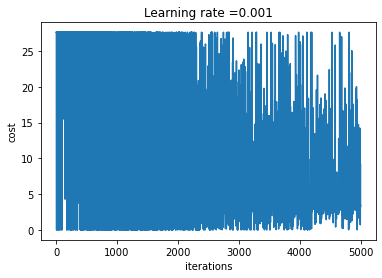

In [121]:

def nn_model_train(X, Y, n_h, learning_rate, num_iterations=10000):
    """
    Arguments:
    X -- training data of shape (3076, number of examples)
    Y -- one-hot encoded true training labels of shape (10, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    # Random generator seed for initialzing parameters
    np.random.seed(2)
    
    # Retrieve input size and output size from row of training data and training labels respectively
    n_x = X.shape[0]
    n_y = Y.shape[0]
    
    cost = [] # to hold loss values after every iteration
    lr = learning_rate
    num_iters = num_iterations # each iteration corresponds to one input image
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    parameters = initialize_parameters(n_x,n_h,n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)
        
    for n in range(num_iters):
            
        # Reshape X and Y to 1D array from rank-1 array
        X_n = X[:,n].reshape(n_x, 1)
        Y_n = Y[:,n].reshape(n_y, 1)
            
        # Forward propagation. Inputs: "X_n, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X_n,parameters)
        
        # Calculate cross-entropy loss for current input and append to cost array.
        e = 0.000001 # added to avoid log(0) when compiler rounds off values of A2 very close to 0/1
        loss = -np.sum(Y_n * np.log(A2+e) + (1-Y_n) * np.log(1-A2+e)) #cross-entropy loss
        cost.append(loss)
 
        # Backpropagation. Inputs: "parameters, cache, X_n, Y_n". Outputs: "grads".
        grads = backward_propagation(parameters,cache,X_n,Y_n)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters,grads,lr)
        
        # Print the cost every 1000 iterations
        if n % 1000 == 0:
            print ("Cost after iteration", n, ":", np.mean(cost))
    
    plt.plot(np.squeeze(cost))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate =" + str(lr))
    plt.show()
    
    return parameters

# pass training data and desired hyperparameters to model
params = nn_model_train(trainData, one_hot_train, 64, 0.001, num_iterations=5000)

# Sanity check: retrieve the trained weights and biases
#print("W1 = " + str(params["W1"]))
#print("b1 = " + str(params["b1"]))
#print("W2 = " + str(params["W2"]))
#print("b2 = " + str(params["b2"]))

In [128]:

def predict(parameters, X, Y):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- Test data of size (3076, num_examples)
    Y -- True test labels of size (1, num_examples)
    
    Returns
    Y_pred -- 1d array containing predicted labels)
    """
    
    Y_p = []
    
    for n in range(X.shape[1]):
        
        X_n = X[:,n].reshape(X.shape[0], 1) # Reshape X to 1D array from rank-1 array
        
        # Computes probabilities using forward propagation
        A2, cache = forward_propagation(X_n, parameters)
        Y_hat = np.argmax(A2, axis=0)
        Y_p.append(Y_hat)
    
    Y_pred = np.array(Y_p)
    acc = ((Y_pred==Y).mean())*100
    print("Test accuracy:", acc)
    
    return Y_pred

# Sanity check to test predict function 

#t_1 = testData[:,0:6]
#t = testLbl[0:6]
#print(t)

#preds = predict(params, t_1, t)
#print(preds)

# Finally, pass in the trained parameters, test data, and true test labels to evaluate prediction accuracy of model
preds = predict(params, testData, testLbl)

Test accuracy: 10.0


The 'Doodle' block below only serves to verify that functions and parameters within the predict function are behaving as expected so please ignore for project purposes.

In [114]:
A = np.array([2,1,1,5])
print(A.shape)
print(np.argmax(A, axis=0))
print(A.shape[0])
A = A.reshape(4,1)
print(A.shape)
print(testLbl.shape)
print(testLbl[0:6])

t = testLbl[0:6]

pred = []
#pred = [2,8,1,4,6,6]
pred.append(2)
pred.append(8)
pred.append(1)
pred.append(4)
pred.append(6)
pred.append(6)

#pred.append([2,8,1,4,6,6])
print(pred)

p = np.array(pred)
print(p)

i = p==t
print (i)
       
acc = ((p==t).mean())*100
print(acc)

(4,)
3
4
(4, 1)
(10000,)
[3 8 8 0 6 6]
[2, 8, 1, 4, 6, 6]
[2 8 1 4 6 6]
[False  True False False  True  True]
50.0
